In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):
    
    nfeatures = 10
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4) + cliff(x5, x6)
        ).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=random_state)

In [3]:
model = GAMINetRegressor(interact_num=10,
                         subnet_size_main_effect=[40] * 5,
                         subnet_size_interaction=[40] * 5, 
                         max_epochs=[1000, 1000, 100],
                         learning_rates=[0.001, 0.001, 0.0001],
                         early_stop_thres=["auto", "auto", "auto"],
                         batch_size=1000,
                         reg_clarity=1,
                         loss_threshold=0.01,
                         warm_start=True,
                         verbose=True,
                         random_state=random_state)
model.fit(train_x, train_y)

####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############


Epoch:    1, train loss: 0.01135, validation loss: 0.01059: 100%|██████████| 7/7 [00:00<00:00, 80.97it/s]                          
Epoch:    2, train loss: 0.01092, validation loss: 0.01002: 100%|██████████| 7/7 [00:00<00:00, 96.35it/s]                          
Epoch:    3, train loss: 0.01064, validation loss: 0.01008: 100%|██████████| 7/7 [00:00<00:00, 102.63it/s]                         
Epoch:    4, train loss: 0.01050, validation loss: 0.00982: 100%|██████████| 7/7 [00:00<00:00, 94.50it/s]                          
Epoch:    5, train loss: 0.01048, validation loss: 0.00975: 100%|██████████| 7/7 [00:00<00:00, 106.66it/s]                         
Epoch:    6, train loss: 0.01041, validation loss: 0.00974: 100%|██████████| 7/7 [00:00<00:00, 95.36it/s]                          
Epoch:    7, train loss: 0.01040, validation loss: 0.00981: 100%|██████████| 7/7 [00:00<00:00, 90.53it/s]                          
Epoch:    8, train loss: 0.01047, validation loss: 0.00977: 100%|██████████|

Main Effect Training Stop at Epoch: 18, train loss: 0.01043, validation loss: 0.00978
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############


Epoch:    1, train loss: 0.00591, validation loss: 0.00624: 100%|██████████| 7/7 [00:00<00:00, 31.43it/s]                          
Epoch:    2, train loss: 0.00435, validation loss: 0.00281: 100%|██████████| 7/7 [00:00<00:00, 25.10it/s]                          
Epoch:    3, train loss: 0.00322, validation loss: 0.00312: 100%|██████████| 7/7 [00:00<00:00, 25.42it/s]                          
Epoch:    4, train loss: 0.00291, validation loss: 0.00252: 100%|██████████| 7/7 [00:00<00:00, 25.22it/s]                          
Epoch:    5, train loss: 0.00271, validation loss: 0.00252: 100%|██████████| 7/7 [00:00<00:00, 28.75it/s]                          
Epoch:    6, train loss: 0.00260, validation loss: 0.00242: 100%|██████████| 7/7 [00:00<00:00, 23.14it/s]                          
Epoch:    7, train loss: 0.00252, validation loss: 0.00241: 100%|██████████| 7/7 [00:00<00:00, 24.16it/s]                          
Epoch:    8, train loss: 0.00252, validation loss: 0.00238: 100%|██████████|

Interaction Training Stop at Epoch: 46, train loss: 0.00238, validation loss: 0.00224
#########################Stage 3: Fine Tuning#########################


Epoch:   1, train loss: 0.00223, validation loss: 0.00218: 100%|██████████| 7/7 [00:00<00:00, 20.21it/s]                           
Epoch:   2, train loss: 0.00217, validation loss: 0.00205: 100%|██████████| 7/7 [00:00<00:00, 22.46it/s]                           
Epoch:   3, train loss: 0.00211, validation loss: 0.00208: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]                           
Epoch:   4, train loss: 0.00212, validation loss: 0.00207: 100%|██████████| 7/7 [00:00<00:00, 22.09it/s]                           
Epoch:   5, train loss: 0.00210, validation loss: 0.00204: 100%|██████████| 7/7 [00:00<00:00, 21.71it/s]                           
Epoch:   6, train loss: 0.00209, validation loss: 0.00205: 100%|██████████| 7/7 [00:00<00:00, 22.62it/s]                           
Epoch:   7, train loss: 0.00210, validation loss: 0.00203: 100%|██████████| 7/7 [00:00<00:00, 22.53it/s]                           
Epoch:   8, train loss: 0.00208, validation loss: 0.00203: 100%|██████████| 

Fine Tuning Stop at Epoch: 40, train loss: 0.00205, validation loss: 0.00199


## Train GAMI-Net 

In [4]:
val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5),
                          np.round(get_metric(val_y, pred_val),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[1.04519 1.03488 1.04708]


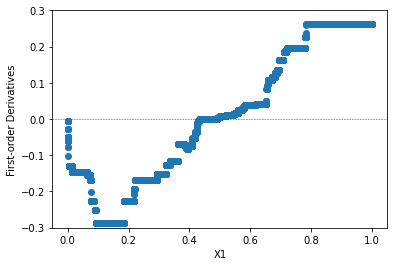

In [5]:
model.partial_derivatives(0)

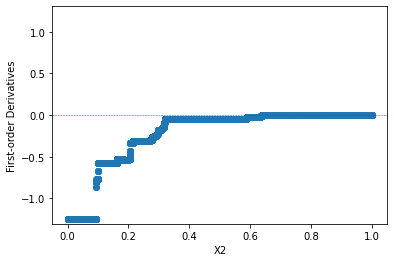

In [6]:
model.partial_derivatives(1)

In [7]:
model.get_clarity_loss(test_x)

0.00016559925279580057

## Visualization

In [8]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

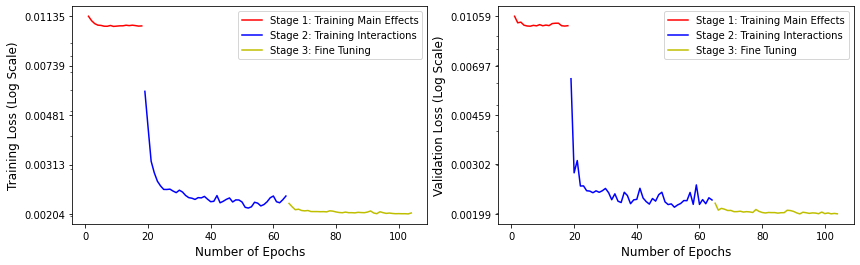

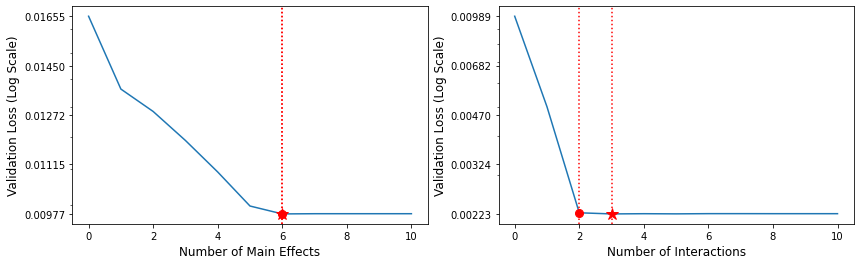

In [9]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=False, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=False, save_eps=False)

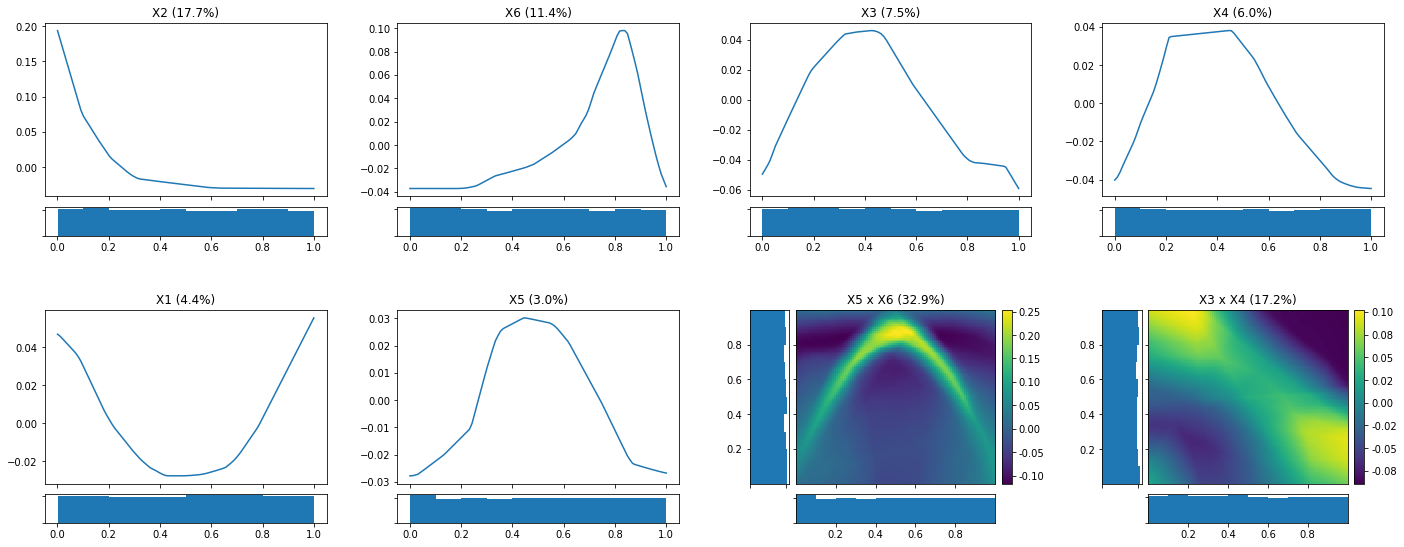

In [10]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, main_effect_num=6, interaction_num=30, cols_per_row=4, save_png=False, save_eps=False)

Feature Importance

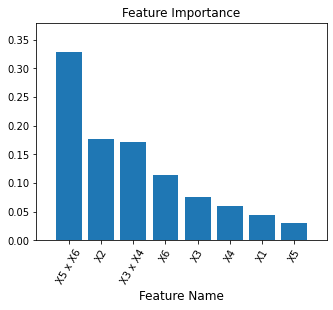

In [11]:
feature_importance_visualize(data_dict_global, save_png=False, folder=simu_dir, name='s1_feature')

Local Visualization

In [12]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

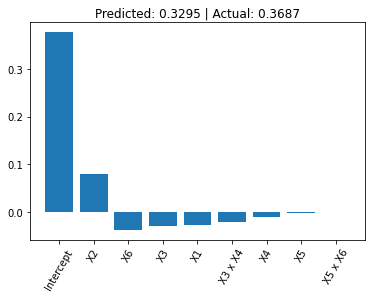

In [13]:
local_visualize(data_dict_local[0], save_png=False, folder=simu_dir, name='s1_local')

## Model save and load 

In [14]:
model.save(name="simu")
modelnew = GAMINetRegressor()
modelnew.load(name="simu")
modelnew.predict(train_x)

array([[0.32947612],
       [0.607202  ],
       [0.5307127 ],
       ...,
       [0.3668409 ],
       [0.16137859],
       [0.22335768]], dtype=float32)